## This notebook walks through locally running mcad and ma bots using naive bot manager

In [29]:
# import necessary libaries 
%reload_ext autoreload
%autoreload 2
import os
os.chdir('..')

from scripts.apimanagers import APImanager
from scripts.assets import Account, Stock
from scripts.botmanagers import Stocks_manager_naive
from scripts.bots import Moving_average_bot, Macd_bot

import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import datetime
import time

### Initialization

In [30]:
# global variables
API_KEY = "PKI9JRCD2UOFVJTJEQ9Y"#<your API_KEY here>
SECRET_KEY = "JQAOBTno6yjE83Ks2tl8NpXnQEarMkMNrao1Hr0s"#<your SECRET_KEY here>
CUR_TIME_DELAYED = (datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(minutes=16))  # 16 minutes delay of current time for bars data
CUR_TIME = (datetime.datetime.now(datetime.timezone.utc))  # 15 minutes delay of current time for bars data
print(CUR_TIME_DELAYED)

2021-06-15 14:55:44.710232+00:00


In [31]:
# create API manager
API_manager = APImanager(API_KEY, SECRET_KEY)

In [32]:
# get some past data for initialization. Let's look at APPL and AMD for this demonstration
hour_bar_apple, hour_bar_apple_t = API_manager.get_bar("AAPL", TimeFrame.Hour, "2021-06-08", CUR_TIME_DELAYED.astimezone().isoformat())
hour_bar_amd, hour_bar_amd_t = API_manager.get_bar("AMD", TimeFrame.Hour, "2021-06-08", CUR_TIME_DELAYED.astimezone().isoformat())

#get current price of the stock for initialization.
cur_price_apple = API_manager.get_price("AAPL")
cur_price_amd = API_manager.get_price("AMD")

In [33]:
# create stock objects
APPL_hour = Stock("AAPL", cur_price_apple, CUR_TIME_DELAYED, hour_bar_apple, TimeFrame.Hour, hour_bar_apple_t[0])
AMD_hour = Stock("AMD", cur_price_amd, CUR_TIME_DELAYED, hour_bar_amd, TimeFrame.Hour, hour_bar_amd_t[0])
STOCKS = [APPL_hour, AMD_hour]

In [34]:
# create bot objects. Give each bot let's say $200,000 asset for trading
BOT_AAPL_ma_hour = Moving_average_bot(APPL_hour, 200000)
BOT_AMD_macd_hour = Macd_bot(AMD_hour, 200000)
BOTS = [BOT_AAPL_ma_hour, BOT_AMD_macd_hour]

In [35]:
# create the bot manager
bot_manager = Stocks_manager_naive(BOTS, None)

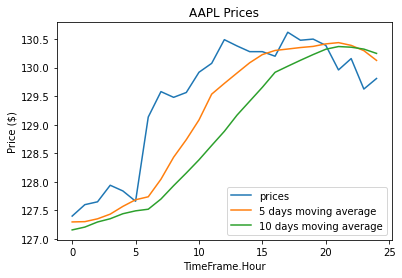

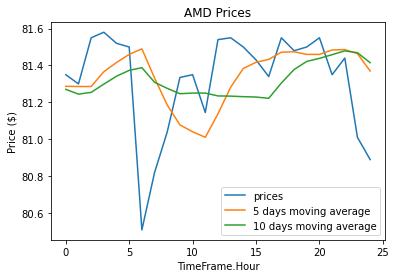

In [36]:
# print some prices for sanity check
APPL_hour.plot_price(25)
AMD_hour.plot_price(25)

### The Main Loop

In [37]:
def update_utils():
    CUR_TIME_DELAYED = (datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(minutes=16))  # 16 minutes delay of current time for bars data
    CUR_TIME = (datetime.datetime.now(datetime.timezone.utc))  # 15 minutes delay of current time for bars data

def update_stocks(passed_minutes = 15): # assumes 15 minutes has passed since the last update
    for s in STOCKS:
        symbol = s.symbol
        timeframe = s.timeframe
        cur_price = API_manager.get_price(symbol)
        bar, bar_t = API_manager.get_bar(symbol, timeframe, (CUR_TIME_DELAYED - datetime.timedelta(minutes=passed_minutes)).astimezone().isoformat(), CUR_TIME_DELAYED.astimezone().isoformat())
        s.update(cur_price, bar, bar_t, CUR_TIME_DELAYED)
        

In [38]:
while True:
    update_utils() # update the utility global variables such as CUR_TIME
    update_stocks() # update the stock objects
    bot_manager.make_decision()
    time.sleep(60) #make decision every 60 seconds
    

TypeError: macd() takes 3 positional arguments but 4 were given